# Figure 1, but for Proxima Centauri b.

Overview of the model set-up for the Proxima b case. The *MassFlux* simulation covers the whole sphere, while the *HighRes* simulation is shown by superimposing a high-resolution grid that covers only the substellar region. The graphic shows cloud condensate (white isosurfaces), surface temperature (shading), and free troposphere wind vectors (arrows), focusing on (a) the day side, with the *HighRes* model domain and the cloud condensate isosurface, and (b) the night side of the planet. The cloud condensate is shown using a threshold of $10^{-5}~kg~kg^{-1}$ of total cloud condensate (liquid water plus ice). This figure is available online as an interactive zoom and rotatable figure.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

## Import necessary libraries

Standard library

In [1]:
import warnings
from pathlib import Path
import utils
import os

warnings.filterwarnings("ignore")

3D visualization and mesh analysis library

In [2]:
import pyvista as pv

Scientific stack

In [5]:
import iris
import iris_grib
import numpy as np
# from netCDF4 import Dataset as nc

In [6]:
from aeolus.const import init_const
from aeolus.plot import subplot_label_generator
from aeolus.plot.pv import grid_for_scalar_cube_sph, grid_for_vector_cubes_sph

Set white background for 3d figures.

In [7]:
pv.set_plot_theme("document")

Global definitions.

## Load data

In [8]:
# const = init_const("proxb")
const = init_const("earth")


In [9]:
datadir = os.getcwd() + "/data"
datadir2 = Path.cwd() / "data"
# datadir = "/Users/erose/cira_workspace/unity_workspace/Py2Unity/Assets/SatelliteData/"
datadir = "/Users/erose/cira_workspace/cira-vertical-cloud-products/hdf_practice/files/files_grib/"
#'2022001_lat_long.npz 20220601_cmr_cloud_presence.npz
# print(os.listdir(datadir))

In [11]:
'''
Notes for tomorrow: You have to load in grib data by specifying the variable_id of the connected variable. In the example below, I'm collecting
"Cloud Mixing Ratio" data and "Cloud Ice Mixing-Ratio" data. The corresponding lat/long values should already be included, but if not, I can grab easily.

wanted coord_system(): GeogCS(7160000.0)

Tomorrow we shoud attempt loading in corresponding lat/long data, and then moving forward to understanding how the plotting works with the related data.
Nonetheless, it looks like we can load in ~all~ HRRR data, by just using the sidestep of specifying the variable id. This is great news and means we can load in data
fairly easily, without having to convert it to other means. Woo hoo!

'''
print(datadir)
# dset_global = iris.load(datadir2 / "proxb_global_t_sfc_u_v_w_cld_liq_mf_cld_ice_mf.nc")
# print(dset_global[0])
# dset_ll = iris.load(datadir + "2022001_lat_long.npz")
dset_cmr = iris_grib.load_cubes(datadir + "20220831hrrr.t23z.wrfprsf00.grib2")#,"cloud_mixing_ratio")#, ["Cloud mixing ratio","Cloud ice mixing-ratio","isobaric","x","y"])
cubes = list(dset_cmr)
lat_proj = cubes[0].coord("projection_y_coordinate").points / 17633.33333333
lon_proj = cubes[0].coord("projection_x_coordinate").points / 14983.33333333
# finalLatProj = np.copy(lat_proj); finalLonProj = np.copy(lon_proj)
# conus_poly = utils.loadCONUSPoly()
# for lat in range(len(lat_proj)):
#     for lon in range(len(lon_proj)):
#         curr_point = (lat_proj[lat],lon_proj[lon])
#         if not utils.insideBounds(curr_point,conus_poly):
#             finalLatProj[lat] = np.nan
#             finalLonProj[lon] = np.nan
cmr_cubes = []; icmr_cubes = []
t_sfc_cubes = []
for cube in cubes:
    # print(cube)
    cube.coord("projection_y_coordinate").points = lat_proj #finalLatProj
    cube.coord("projection_x_coordinate").points = lon_proj #finalLonProj
    ax = str(cube.aux_coords)
    attr = str(cube.attributes["GRIB_PARAM"])
    if attr == "GRIB2:d000c001n022":
        # print(cube.standard_name)
        cmr_cubes.append(cube)
    elif attr == "GRIB2:d000c001n082":
        # print("Cloud ice mixing-ratio")
        cube.units  = "kg kg-1"
        icmr_cubes.append(cube)
    elif attr  == "GRIB2:d000c000n000" and "height" in ax:
        t_sfc_cubes.append(cube)
    # print(cube.coord("projection_y_coordinate").points)
    # print(cube.coord("projection_x_coordinate").points)
    # print(cube.coord_system())

print("Cloud mixing ratio cubes: ", np.shape(cmr_cubes))
print("Cloud ice mixing-ratio cubes: ", np.shape(icmr_cubes))
print("Temp sfc cubes ", np.shape(t_sfc_cubes))
'''
cube = iris.load_cube(filename, 'electron density')
equator_constraint = iris.Constraint(grid_latitude=0)
height_constraint = iris.Constraint(height=9000)
equator_height_9km_slice = cube.extract(equator_constraint & height_constraint)
'''
# print(dset_cmr)
# cubes = list(dset_global)
# print(dset_cmr.shape)
# for lvl in dset_cmr:
#     try:
#         print(lvl.data)
#     except:
#         print("No data for this level")

# for idx, var in enumerate(dset_global):
#     print()
#     print("var = " + str(idx), var.long_name)


# dset_lam = iris.load(datadir / "proxb_lam_cld_mf.nc")

/Users/erose/cira_workspace/cira-vertical-cloud-products/hdf_practice/files/files_grib/


ValueError: The 'projection_y_coordinate' DimCoord points array must be strictly monotonic.

## Create `pyvista` objects for a composite plot

Set cloud condensate isosurface threshold.

In [67]:
CC_ISOSURF = [1e-5]  # [kg kg-1]
RADIUS = float(const.radius.data)  # Planet radius [m]
RADIUS

6371200.0

Set viewpoints.

In [68]:
CAM_POS_LATS = [35, 55]
CAM_POS_LONS = [-110, -160]

# CAM_POS_LATS = [10, 20]
# CAM_POS_LONS = [30, 120]

### Global

Set common visualisation propeties.

In [99]:
z_scale = 75.0
z_offset = RADIUS * 1.005

Create a grid for the surface temperature.

In [100]:
# t_sfc = dset_global.extract_cube("cloud_mixing_ratio")
# print(t_sfc.data)
#Lat/Long points are structured as two 1D arrays of lats and longs of different sizes (144 - lats, 192 - lons)
# lats = t_sfc.coord("latitude").points
# lons = t_sfc.coord("longitude").points
# print("shape = " + str(np.shape(lats)) + str(np.shape(lons)))
# print("lats", lats); print("lons", lons)
# longs = t_sfc.extract("longitude")
# print(lats.data)
# grid_sfc = grid_for_scalar_cube_sph(cmr_cubes[35], z_offset=z_offset, label="global_sfc_grid", isHrrr=True)
print(t_sfc_cubes[0].data)
print(t_sfc_cubes[0].coord("projection_y_coordinate").points)
grid_sfc = grid_for_scalar_cube_sph(t_sfc_cubes[0], z_offset=z_offset, label="global_sfc_grid", isHrrr=True)
# print(cmr_cubes[0].coord("projection_x_coordinate").points)

[[296.55041504 296.55041504 296.55041504 ... 302.17541504 302.17541504
  302.11291504]
 [296.48791504 296.48791504 296.48791504 ... 302.17541504 302.17541504
  302.17541504]
 [296.48791504 296.48791504 296.48791504 ... 302.17541504 302.17541504
  302.17541504]
 ...
 [290.17541504 290.17541504 290.17541504 ... 292.17541504 292.11291504
  292.11291504]
 [290.17541504 290.17541504 290.17541504 ... 292.17541504 292.11291504
  292.05041504]
 [290.17541504 290.17541504 290.17541504 ... 292.05041504 292.05041504
  292.05041504]]
[-90.01736215 -89.84722982 -89.6770975  ...  89.6423732   89.81250553
  89.98263785]


Extract 3 wind components from the global model output.

In [ ]:
wind_levels = [5000]  # [m]

winds = dset_global.extract(
    iris.Constraint(level_height=lambda x: x in wind_levels)
).extract(["x_wind", "y_wind", "upward_air_velocity"])

Create a grid for the wind vectors.

In [ ]:
grid_vec = grid_for_vector_cubes_sph(
    *winds,
    vector_scale=RADIUS * 0.004,
    vertical_wind_scale=1e2,
    z_scale=z_scale,
    z_offset=z_offset,
    xstride=1,
    ystride=1,
    label="global_wind_vectors_grid",
)

In [ ]:
grid_vec

Create glyph objects to show wind vectors.

In [ ]:
glyphs = grid_vec.glyph(
    orient="global_wind_vectors_grid",
    scale="global_wind_vectors_grid",
    tolerance=0.035,
)

Extract the total cloud condensate.

In [101]:
# global_qct = sum(
#     dset_global.extract_cubes(
#         [
#             "mass_fraction_of_cloud_liquid_water_in_air",
#             "mass_fraction_of_cloud_ice_in_air",
#         ]
#     )
# )
# global_qct = sum(iris.cube.CubeList(cmr_cubes)) + sum(iris.cube.CubeList(icmr_cubes))
# print(global_qct)

summed = np.zeros((40,1059,1799),dtype="float32")
for cube in range(len(cmr_cubes)):
    try:
        sum_data = np.zeros((1059,1799),dtype="float32")
        sum_data += cmr_cubes[cube].data
        sum_data += icmr_cubes[cube].data
        summed[cube] = sum_data
        # print(cube.data)
    except Exception as e:
        print(e)
total_cmr_cubes = cmr_cubes
for lvl in range(len(summed)):
    total_cmr_cubes[lvl].data = summed[lvl]
total_cmr_cubes = iris.cube.CubeList(total_cmr_cubes)
cmr_single_src = total_cmr_cubes.merge_cube()
print(cmr_single_src.coord("projection_y_coordinate").points)
print(cmr_single_src.coord("projection_x_coordinate").points)
print(cmr_single_src)

"'codedValues' not defined in section 7"
"'codedValues' not defined in section 7"
[-90.01736215 -89.84722982 -89.6770975  ...  89.6423732   89.81250553
  89.98263785]
[-180.03471474 -179.83449227 -179.6342698  ...  179.56484032  179.76506279
  179.96528526]
cloud_mixing_ratio / (kg kg-1)      (pressure: 40; projection_y_coordinate: 1059; projection_x_coordinate: 1799)
    Dimension coordinates:
        pressure                             x                            -                              -
        projection_y_coordinate              -                            x                              -
        projection_x_coordinate              -                            -                              x
    Scalar coordinates:
        forecast_period             0 hours
        forecast_reference_time     2022-08-31 23:00:00
        time                        2022-08-31 23:00:00
    Attributes:
        GRIB_PARAM                  GRIB2:d000c001n022


Create a grid for the cloud condensate and extract a 3D contour (isosurface).

In [102]:
# cmr_cubeList = iris.cube.CubeList(total_cmr_cubes)
# print(total_cmr_cubes)
global_qct_cntr = (
    grid_for_scalar_cube_sph(
        cmr_single_src, z_scale=z_scale, z_offset=z_offset, label="global_qct_grid", isHrrr=True
    )
    .cell_data_to_point_data()
    .contour(isosurfaces=CC_ISOSURF)
)

### HighRes

Set common visualisation propeties.

In [148]:
z_scale = 50.0
z_offset = RADIUS * .89
# TOPLEV = 60
# DLEV = 2  # use every 2nd level
# DY = 3  # stride along y-coordinate
# DX = 3  # stride along x-coordinate

Extract the total cloud condensate from the *HighRes* simulation.

In [128]:
# lam_qct = dset_lam.extract_cube(
#     "mass_fraction_of_cloud_condensed_water_in_air",
# )
lam_qct = cmr_single_src

Create a grid from the 3D total cloud condensate field.

In [149]:
lam_grid = grid_for_scalar_cube_sph(
    lam_qct,
    z_scale=z_scale,
    z_offset=z_offset,
    label="lam_qct_grid", isHrrr=True
)

Create an isosurface of the cloud condensate.

In [150]:
lam_qct_cntr = lam_grid.cell_data_to_point_data().contour(isosurfaces=CC_ISOSURF)

Extract a mesh from the HighRes data.

In [151]:
lam_dom = (
    grid_for_scalar_cube_sph(
        lam_qct[:, ::7, ::7],
        z_scale=z_scale,
        z_offset=z_offset,
        label="lam_dom", isHrrr=True
    )
    .extract_geometry()
    .extract_all_edges()
)

2023-04-18 11:03:03.609 (5231.893s) [            94BF]    vtkExtractEdges.cxx:435   INFO| Executing edge extractor: points are renumbered
2023-04-18 11:03:03.693 (5231.978s) [            94BF]    vtkExtractEdges.cxx:551   INFO| Created 221696 edges


## Prepare data for plotting

Pack grids and plotting arguments into a single list.

In [153]:
VIS_CONTAINER = [
    {
        # Global surface temperature
        "mesh": grid_sfc,
        "kwargs": {
            "cmap": "plasma",
            "clim": [240,330],
            "show_scalar_bar": False,
            "smooth_shading": True,
        },
    },
    # {
    #     # Global wind vectors
    #     "mesh": glyphs,
    #     "kwargs": {"cmap": "Greys", "scalars": "GlyphScale", "show_scalar_bar": False},
    # },
    # {
    #     # Global cloud condensate
    #     "mesh": global_qct_cntr,
    #     "kwargs": {
    #         "color": "#ededff",
    #         "clim": [1e-05, 1e-05],
    #         "opacity": 0.5,
    #         "show_scalar_bar": False,
    #         "smooth_shading": True,
    #     },
    # },
    {
        # HighRes cloud condensate
        "mesh": lam_qct_cntr,
        "kwargs": {
            "color": "#ebebff",
            "clim": [1e-05, 1e-05],
            "opacity": 1.0,
            "show_scalar_bar": False,
            "specular": 0.5,
            "ambient": 0.5,
            "smooth_shading": True,
        },
    },
    {
        # HighRes domain edges
        "mesh": lam_dom,
        "kwargs": {
            "style": "wireframe",
            "color": "k",
            "opacity": 0.2,
            "smooth_shading": True,
        },
    },
]

## Plot the results

Assemble the plot.

In [154]:
iletters = subplot_label_generator()
# pv.global_theme.interactive = True
# pv.set_jupyter_backend("panel")

p = pv.Plotter(shape=(1, len(CAM_POS_LONS)), window_size=np.array([1024, 768 // 2]) * 2)

for idx, (cam_lon, cam_lat) in enumerate(zip(CAM_POS_LONS, CAM_POS_LATS)):
    p.subplot(0, idx)

    p.add_text(f"({next(iletters)})", font="times", font_size=24)

    for plot_dict in VIS_CONTAINER:
        p.add_mesh(plot_dict["mesh"], **plot_dict["kwargs"])

    p.set_position(pv.grid_from_sph_coords([cam_lon], [90 - cam_lat], [4.5e7]).points)
    p.set_focus((0, 0, 0))
    p.set_viewup((0, 0, 1))

## Show the figure

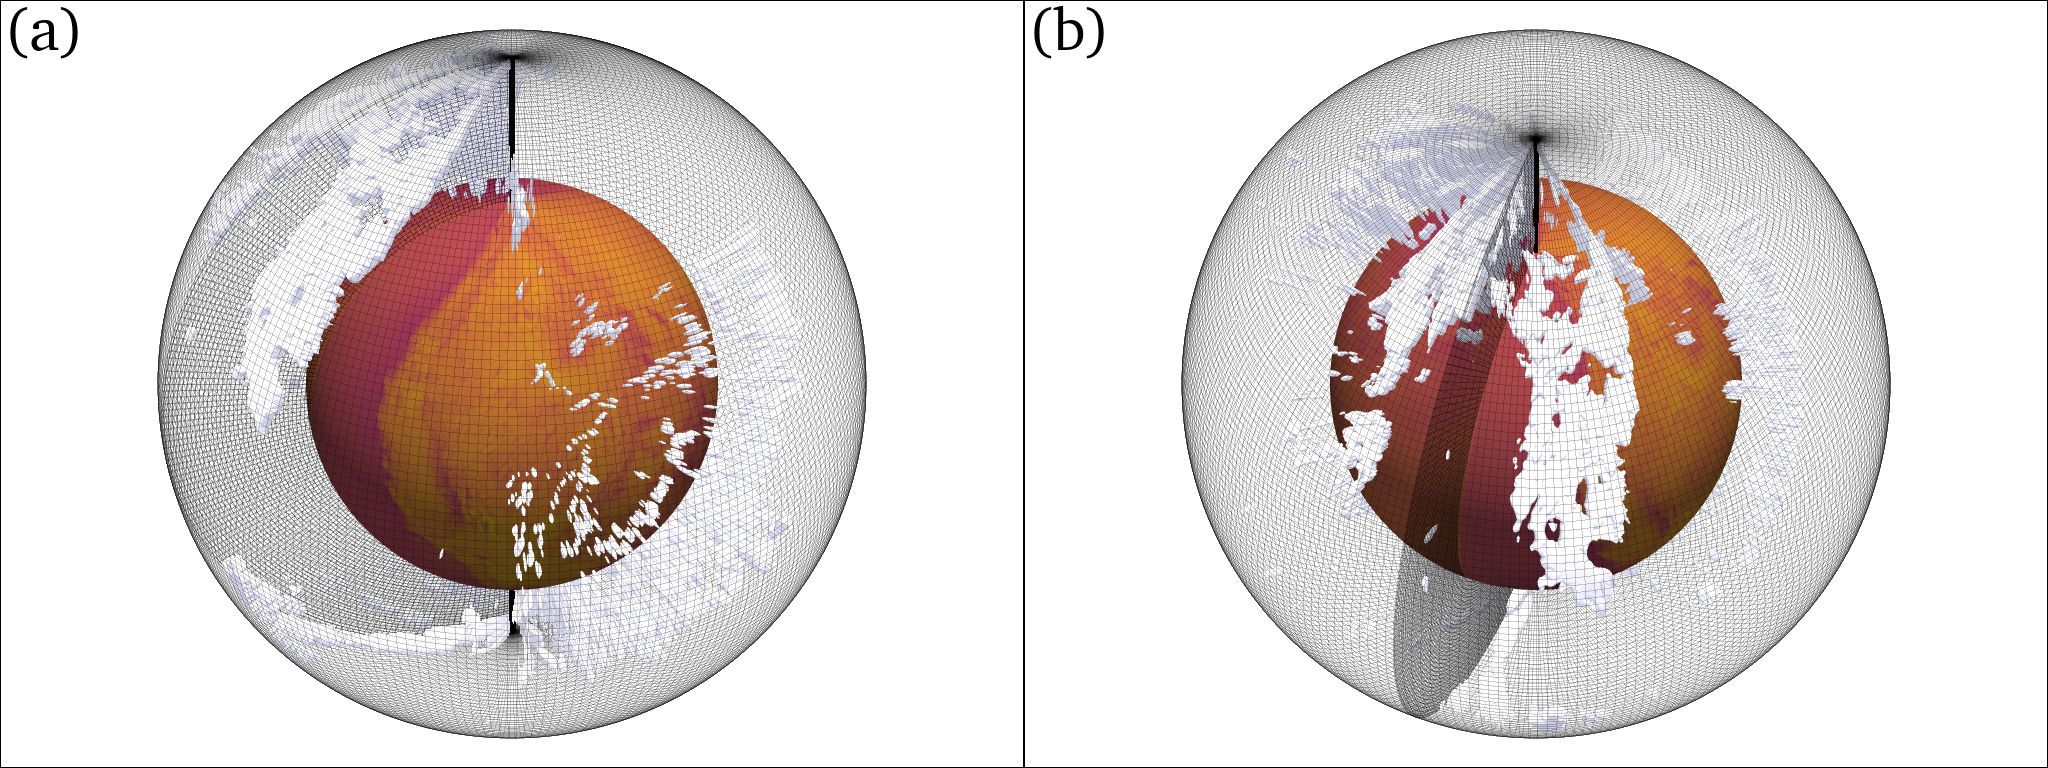

In [155]:
# p.show()
p.show(jupyter_backend="static")
# p.plot()